# Analytics

In [1]:
import os
import glob
import psycopg2
import pandas as pd
import numpy as np
import configparser

config = configparser.ConfigParser()
config.read('dwh.cfg')

conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor()

conn.set_session(autocommit=True)

## Schema size

In [4]:
df = pd.read_sql("""
select name, sum(rows) as rows
from stv_tbl_perm
where name = 'artists' or name = 'songs' OR name = 'users' OR name = 'songplays' 
OR name = 'staging_events' OR name = 'staging_songs'
group by 1 ORDER BY rows DESC
          """, conn)
df.head()

,name,rows
0,staging_events ...,32224
1,songs ...,14896
2,staging_songs ...,14896
3,artists ...,9553
4,songplays ...,319


## Which songs are users listening to the most (Top15)

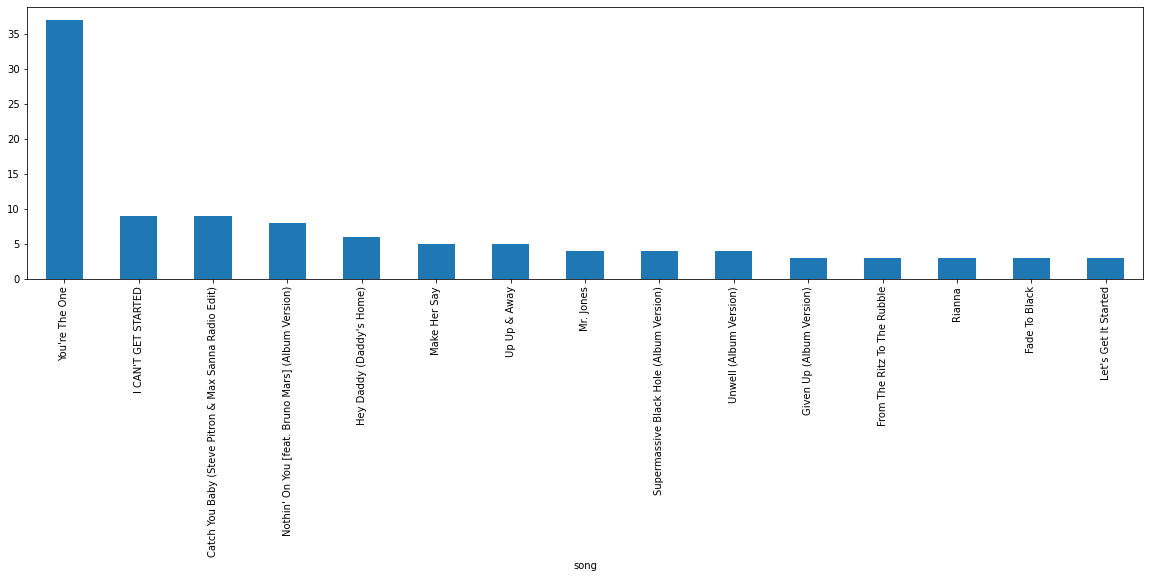

In [5]:
df = pd.read_sql("""
        SELECT j.name as artist, h.title as song, COUNT(title) as users 
          FROM songplays g
               INNER JOIN songs h ON g.song_id = h.song_id
               INNER JOIN artists j ON g.artist_id = j.artist_id
          GROUP BY title, artist ORDER BY COUNT(title) DESC LIMIT 15
          """, conn)
df.plot(x='song', y='users', kind='bar', legend=False, figsize=(20,5))

## When are most users active during the day

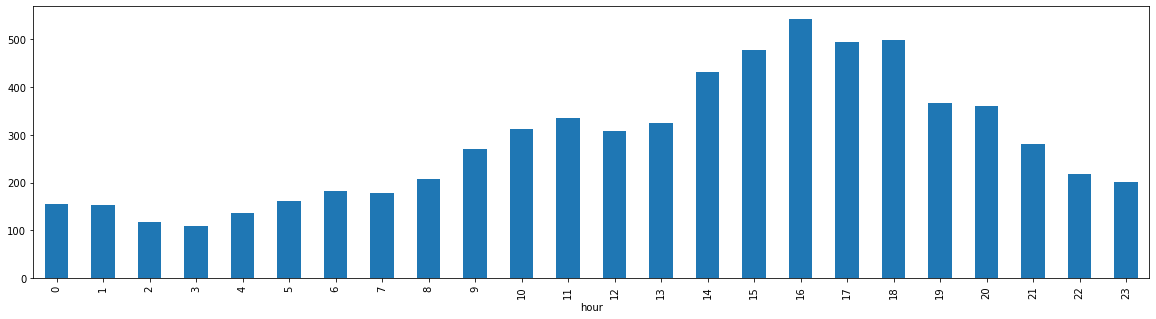

In [4]:
df = pd.read_sql("""SELECT COUNT(hour) as users, hour FROM songplays g 
                INNER JOIN time h ON g.start_time = h.start_time GROUP BY hour ORDER BY hour""", conn)
df.plot(x='hour', y='users', kind='bar', legend=False, figsize=(20,5))

## When are most users active during the month

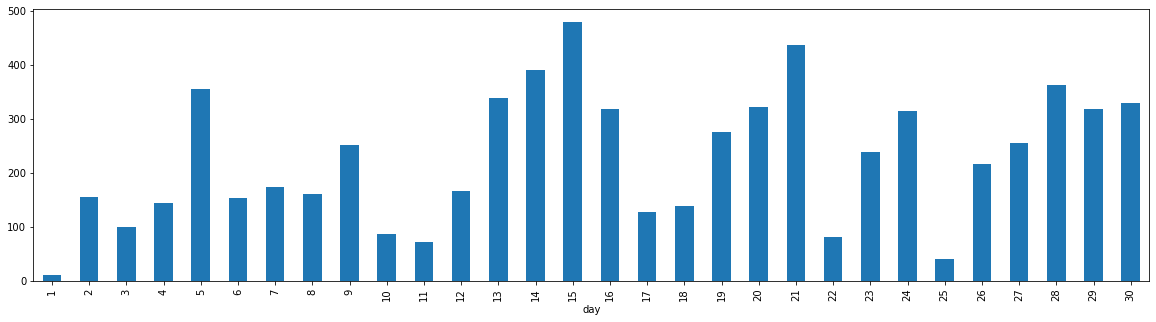

In [5]:
df = pd.read_sql("""SELECT COUNT(day) as users, day FROM songplays g 
                INNER JOIN time h ON g.start_time = h.start_time GROUP BY day ORDER BY day""", conn)
df.plot(x='day', y='users', kind='bar', legend=False, figsize=(20,5))

## Which cities have the highest user activity (Top20)

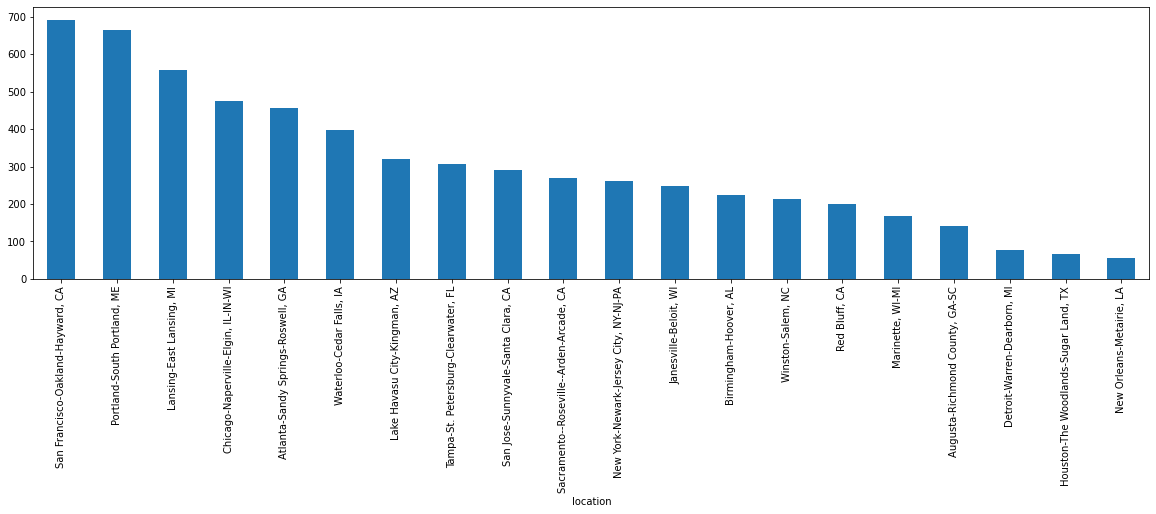

In [6]:
df = pd.read_sql("""SELECT COUNT(location) as users, location FROM songplays 
                GROUP BY location ORDER BY COUNT(location) DESC LIMIT 20""", conn)
df.plot(x='location', y='users', kind='bar', legend=False, figsize=(20,5))

## How many paying users

,users,level
0,82,free
1,22,paid


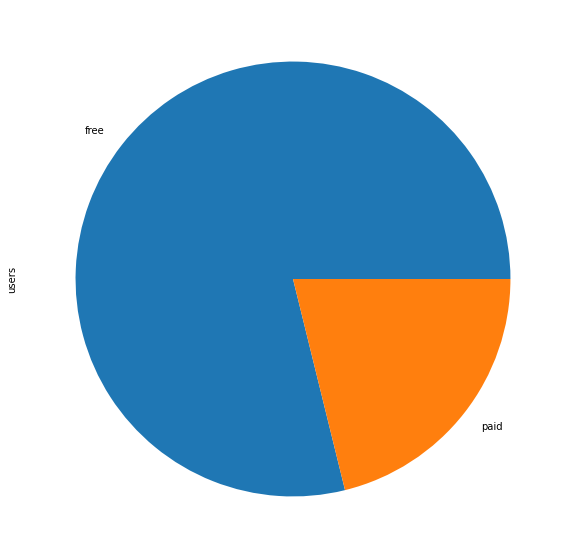

In [7]:
df = pd.read_sql("""SELECT COUNT(level) as users, level FROM (SELECT DISTINCT user_id, level FROM songplays) g
                GROUP BY level ORDER BY level""", conn)
df.plot(x='level', y='users', kind='pie',labels=['free', 'paid'],  legend=False, figsize=(10,10))
df.head()